This is my seventh kernel series contribution to <a href="https://www.kaggle.com/c/ds4g-environmental-insights-explorer/overview"> DS4G: Environmental Insights Explorer </a> to analyze the impacts of air pollution at a particular Geographical area and location

In this kernel, methdology to calculate emission factor of electricity for another geographical area is detailed


<a href="#componenta">**Compenent A: Architecture to calculate emission factor in Puerto Rico region **</a>
*     <a href="#overviewcomponenta">Overview</a>
*     <a href="#trainmodel">Step 1: Train Model</a>
*     <a href="#modelselection">Step 2: Model selection</a>
*     <a href="#utilizemodeltrained">Step 3: Utilize Model Trained</a>

<a href="#componentb">**Compenent B - Extending Architecture to another Geographical Region**</a>
*     <a href="#powerplantSubregions">Guidelines to extend architecture to another Geographical Region</a>


<p id="dataIntegration" style="color:#703bdb; font-size:20px">Compenent A: Architecture to calculate emission factor in Puerto Rico region</p>
<hr size="30">

Will detail Architecture to calculate emission factor in Puerto Rico region using Machine Learning techniques


<p id="overviewcomponenta" style="color:#703bdb; font-size:20px">Overview</p>
<hr size="30">

Till now, we went through 6 kernels, it explained data pre-processing, analysis framework and methdology to calculate emission factor. These require scientific formulas to derive emission factor. In this kernel we detail about how to train the model using data derived from kernel 1 to 6 and how to predict emission factor for a given date without using scientific formulas but using machine learning algorthirms. 

The architecture looks as below to derive emission factor using machine learning algorthirms.

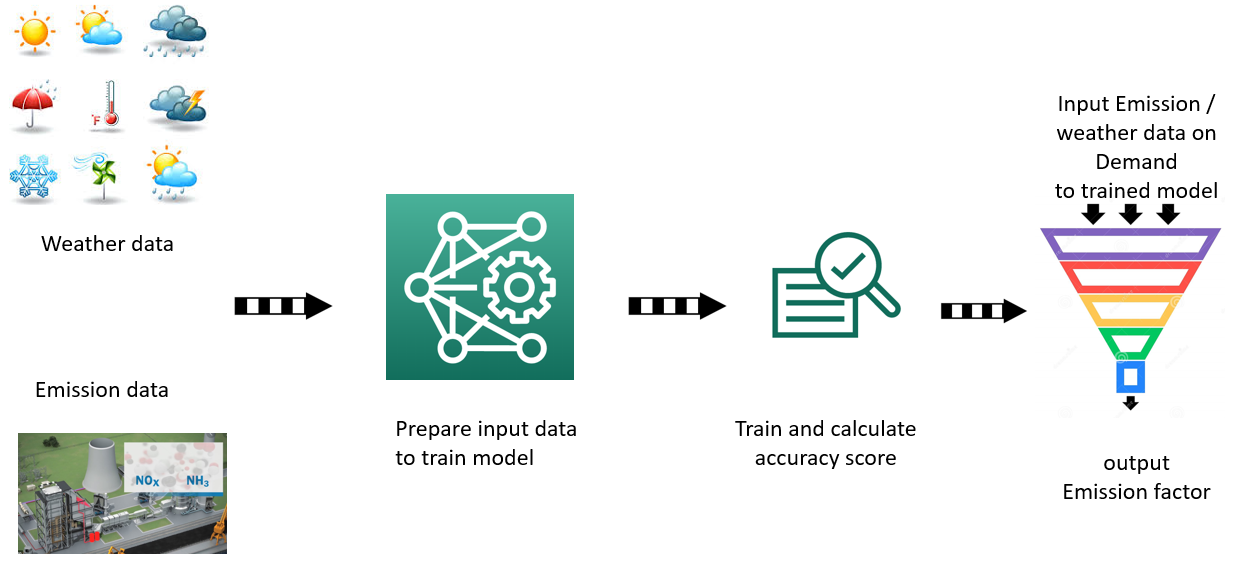

<p id="trainmodel" style="color:#703bdb; font-size:20px">Step 1: Train Model</p>
<hr size="30">

In this step, will train the model by feeding the data to the machine learning algorithm. 

We tried to train the model with below Machine learning and Deep Learning algorithm and we received the best accuracy while training the model using the Random Forest algorithm. 

1. Linear Regression
2. Random Forest
2. XGBoost
3. Artificial Neural Network

Steps to train the model:

1) Joined the weather and emission data on date and region name

2) Splitted the dataset, 80% of data for a train purpose and 20% of data for test purpose

3) Train the model

4) Cross validation with 5 folds

5) Each sub region, provide different output model. Selecting the model which has better accuracy for predicting.

5) Save trained model to disk


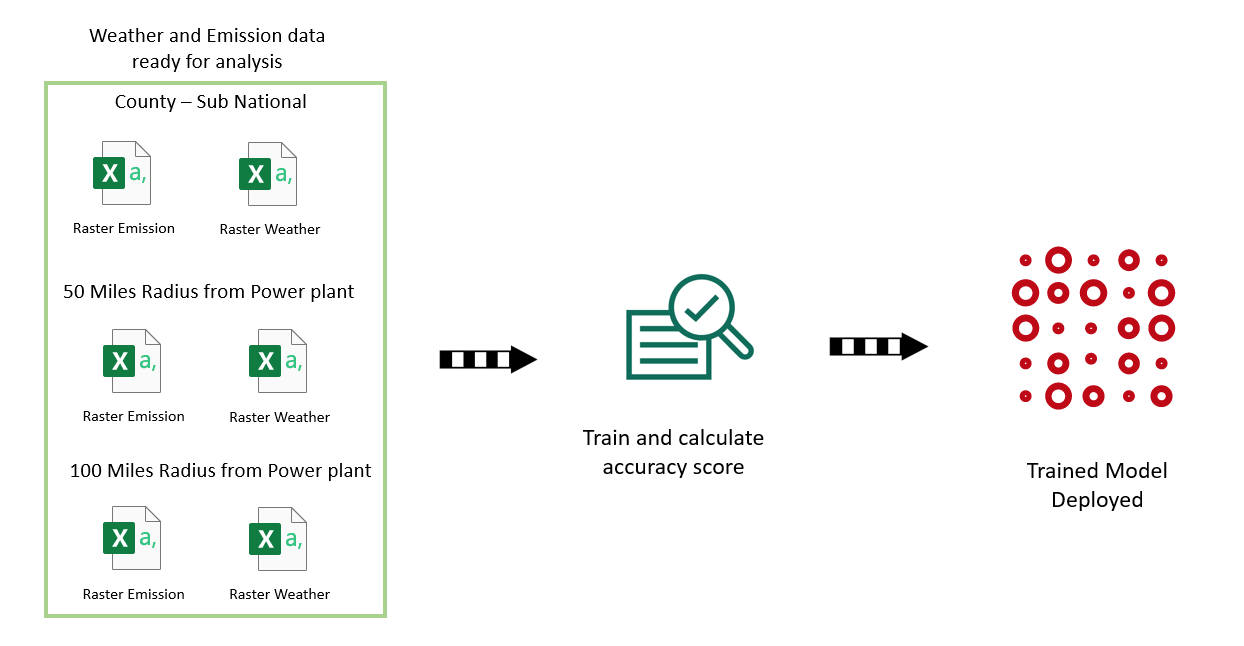

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from emissionglobals import algorithmTypes
from sklearn import metrics
from emissionglobals import modelTrained
import pickle

class emissionModel():
    def __init__(self, appGlobal):
        self.appGlobal = appGlobal
        self.objAppConfig = appGlobal.objAppConfig
        self.config = self.objAppConfig.getConfig()
        self.outputPath =  self.appGlobal.outputPath
        self.modelTrain = []

    def createModel(self, algorithmType):
        '''
            Read data to be trained and trigger train model function for the provided algorithm type
        '''
        try:
            requiredFields = self.objAppConfig.getAllTrainFields()
            requiredFields.append('emissionFactor')

            for dir in os.listdir(self.outputPath):
                print("Training the model for the sub national region - " + dir)
                if os.path.isdir(self.outputPath + dir):
                    csvEmissionArr = [pd.read_csv(fi) for fi in glob.glob(self.outputPath + dir + "/RasterEmission_*.csv")]
                    csvWeatherArr = [pd.read_csv(fi) for fi in glob.glob(self.outputPath + dir + "/RasterWeather_*.csv")]
                    df_Emission = pd.concat(csvEmissionArr)
                    df_Weather = pd.concat(csvWeatherArr)

                    df_modelData = pd.merge(df_Emission, df_Weather, on=['Date',dir])
                    df_modelData = df_modelData[requiredFields]

                    x = df_modelData.iloc[:,:-1]
                    y = df_modelData.iloc[:, -1]

                    self.runAlgorithm(x, y, algorithmType, self.outputPath + dir, df_Emission)

            finalModel = None

            for md in self.modelTrain:
                if finalModel == None:
                    finalModel = md
                else:
                    if(finalModel.modelTrainCoef < md.modelTrainCoef and \
                        finalModel.modelTestCoef < md.modelTestCoef and finalModel.modelRMSE > md.modelRMSE):
                        finalModel = md

            modelPath = os.path.dirname(os.path.dirname(self.appGlobal.outputPath))            
            pickle.dump(finalModel.modelObj, open(modelPath + "\\emissionModel_trained.h5", 'wb'))

        except Exception as e:
            print(e)
            print("Failed at emissionmodel.py - createModel")
            raise
        
    def runAlgorithm(self, x, y, algorithmType, outputPath, xdummy):
        '''
           Traing the model for provided data and algorithm type
        '''
        try:
            x_train, x_test,y_train, y_test = train_test_split(x, y)
            mdl = None
            mt = modelTrained()
            
            if algorithmTypes.randomForestRegression == algorithmType:
                from sklearn.ensemble import RandomForestRegressor
                mt.modelObj = RandomForestRegressor(n_estimators=100)            

            if algorithmTypes.linearRegression == algorithmType:            
                from sklearn.linear_model import LinearRegression
                mt.modelObj = LinearRegression()

            if algorithmTypes.xgboost == algorithmType:            
                import xgboost as xgb  
                mt.modelObj = xgb.XGBRegressor()
                
            #Train the model
            mt.modelObj.fit(x_train, y_train)

            # Cross validating
            score = cross_val_score(mt.modelObj, x_train, y_train, cv=5)
            mean_score = score.mean()
            print("Cross validation -- Mean score " + str(mean_score))

            # calculating the Root mean square error
            mt.modelTrainCoef = mt.modelObj.score(x_train, y_train)
            mt.modelTestCoef = mt.modelObj.score(x_test, y_test)
            print('Co-efficient of determination -- on train set - ', mt.modelTrainCoef)
            print('Co-efficient of determination -- on test set - ', mt.modelTestCoef)

            #mode evaluation
            y_prediction = mt.modelObj.predict(x_test)

            # calculating the Root mean square error
            mt.modelMSE = metrics.mean_squared_error(y_test, y_prediction)
            mt.modelRMSE = np.sqrt(mt.modelMSE)
            
            print('MSE - ', mt.modelMSE)
            print('RMSE - ', mt.modelRMSE )

            # Plot test and prediction data
            sns.scatterplot(y_test, y_prediction)
            plt.xlabel = "Prediction data"
            plt.ylabel = "Test Data"

            self.modelTrain.append(mt)
            
            plt.savefig(outputPath + "/"+ algorithmType+"_train_coeff"+str(mt.modelTrainCoef)+"_test_coeff_"+str(mt.modelTestCoef)+".png")
        except Exception as e:
            print(e)
            print("Failed at emissionmodel.py - runAlgorithm")
            raise


<p id="modelselection" style="color:#703bdb; font-size:20px">2. Model Selection</p>
<hr size="30">


We went through co-efficient factor, MSE and RMSE values of different algorithm. We received the best accuracy result with Random Forest Algorithm as below. Hence we choosen this saved this trained model to disk and using this model to predict the emission factor

<font color="green"> Accuracy using the emission data for sub national region - powerplant_100Miles </font>
<br/>
<br/>
Co-efficient of determination -- on train set -  0.9997355344690939

Co-efficient of determination -- on test set -  0.995034041776702

MSE -  0.0002533805794829245

RMSE -  0.01591793263847176
<br/>
<font color="green"> Accuracy using the emission data for sub national region - powerplant_10Miles </font>
<br/>

Co-efficient of determination -- on train set -  0.9975558449139813

Co-efficient of determination -- on test set -  0.9894919952706159

MSE -  6.455504930415938e-07

RMSE -  0.0008034615691130434
<br/>
<font color="green"> Accuracy using the emission data for sub national region - powerplant_50Miles </font>
<br/>
<br/>
Co-efficient of determination -- on train set -  0.9976996563453595

Co-efficient of determination -- on test set -  0.9929606559574589

MSE -  3.281562321673379e-05

RMSE -  0.0057284922289144976


<font color="green"> Scattered plot of Accuracy for sub national region - powerplant_50miles </font>

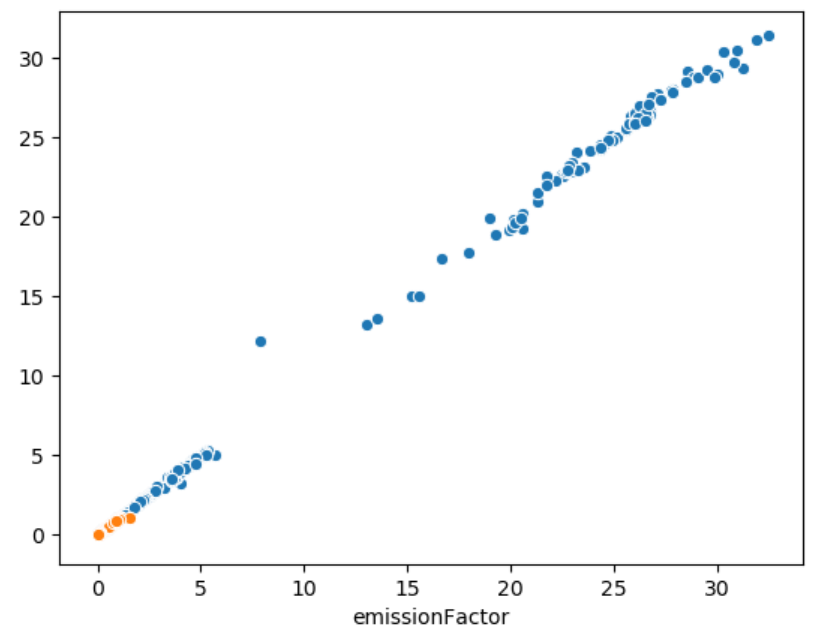

<p id="utilizemodeltrained" style="color:#703bdb; font-size:20px">Step 3: Utilize Model Trained</p>
<hr size="30">

Below are the steps used to utilize the train model

1. Satelite imagery to be predicted should be place with below folder structure

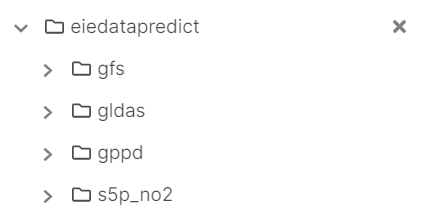

2. Setup config (contain data source path to predict, trained model location, bands to be considered)

Predicted imagery path will be specified in configuration file as below. It use the same format of configuration file use in training the model to make code reuse. For more details of configuration file visit <a href="https://www.kaggle.com/nagabilwanth/step-1-create-a-configuration-file">Configuration details</a>

"sentinel-5P":{ <br />
        "type":"RasterEmission",<br />
        "concatType":"sum",<br />
        "data_Path":"/kaggle/input/eiedatapredict/s5p_no2/",<br />
        "file_format":"s5p_no2_%Y%m%d",<br />
        "filename_Start_at":-1,<br />
        "filename_End_at": 16,<br />

2. Load <a href="https://www.kaggle.com/nagabilwanth/ds4gmodel" >Trained Model</a>

3. Pass the two input parameter to EmissionPrediction.py script

"Date" - The satelite imagery for the date you want to predict

"Sub Region" - Sub Region name "County", "powerplant_50Miles", "powerplant_100Miles"


4. Predict the emission factor

For testing purpose we hardcoded input parameters in <a href="https://www.kaggle.com/nagabilwanth/emissionprediction">Emission Prediction Kernel</a> as below

if __name__ == "__main__": <br/>
    args=["","07-04-2018","County"]<br/>
    main(args)<br/>






Emission Factor predicted using the Machine Learning shows as below

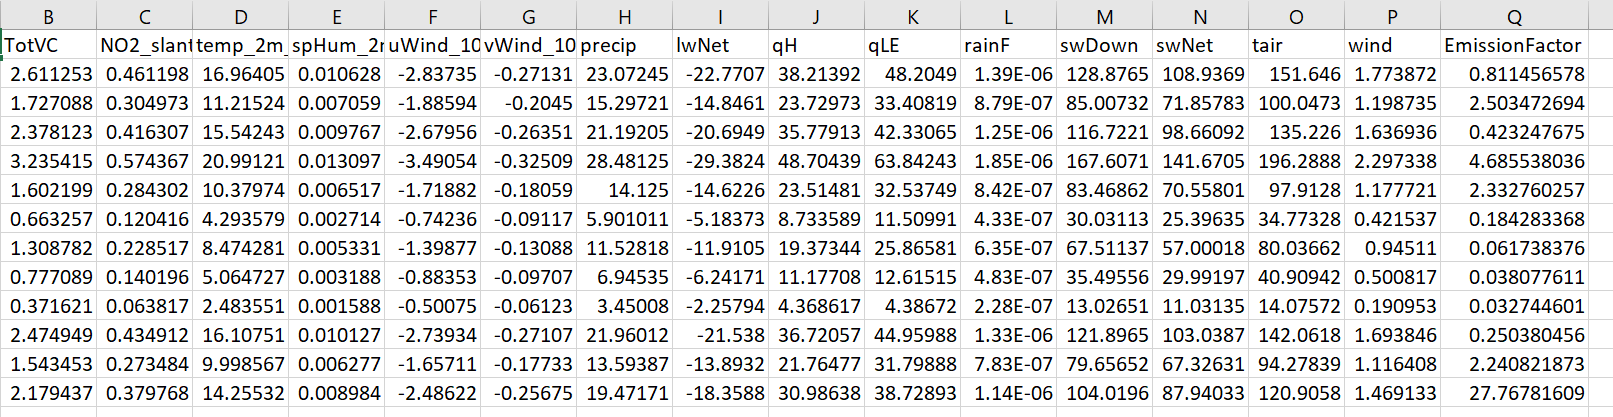

<p id="componentb" style="color:#703bdb; font-size:20px">Compenent B - Extending Architecture to another Geographical Region</p>
<hr size="30">

Below details explain how to utilize the implementation of the Puerto Rico region to other Geographical areas
<br />
<br />
<p id="powerplantSubregions" style="color:#703bdb; font-size:20px">Guidelines to extend architecture to another Geographical Region</p>

The Trained model of the Puerto Rico region can be directly utilized to find the emission factors of the other Geographical area if the amount of error is less. Follow the steps available here  <a href="#utilizemodeltrained">Step 3: Utilize Model Trained</a>.

If error rate is high, then Model need to be trained using GPPD csv file for the geographical regions, Sentinel 5P, GFS and GLDAS satelite image using below steps

1) Setup the configuration file. For more details of configuration file visit <a href="https://www.kaggle.com/nagabilwanth/step-1-create-a-configuration-file">Configuration details</a>

2) Create the emission explorer dataset with below architecture. If you want to change folder structure, change accordingly in the configuration file

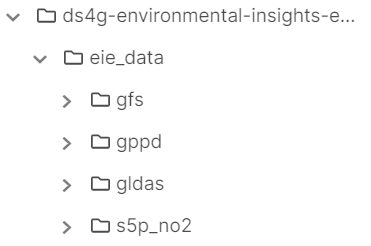

3) Replace the configuration file created for the geographical area.

4) Execute the script <a href="https://www.kaggle.com/nagabilwanth/emissionexplorer">emissionExplorer.py</a>
This script generates the trained model.

5) Replace the trained model and follow the steps in  <a href="#utilizemodeltrained">Step 3: Utilize Model Trained</a>